## Evaluate Images

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import os
import matplotlib
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd

## Define custom metric and load model

In [7]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None,
               **kwargs):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [8]:
model = tf.keras.models.load_model('models/PowderBed_model',custom_objects={'UpdatedMeanIoU':UpdatedMeanIoU})

In [9]:
input_dir = "Job_Images"
jobfilenames = sorted([fname for fname in os.listdir(input_dir) if not fname.startswith(".")])
print(len(jobfilenames))

132


In [50]:
# divide list into sublists for each job
jobfilenames2=[]
jobfilenames2.append(jobfilenames[0:34])
jobfilenames2.append(jobfilenames[34:66])
jobfilenames2.append(jobfilenames[66:99])
jobfilenames2.append(jobfilenames[99:132])

In [38]:
%run -i evaluation_functions.py

1/1 [==============================] - 1s 776ms/step
0:00:00.852355
852


(-0.5, 749.5, 749.5, -0.5)

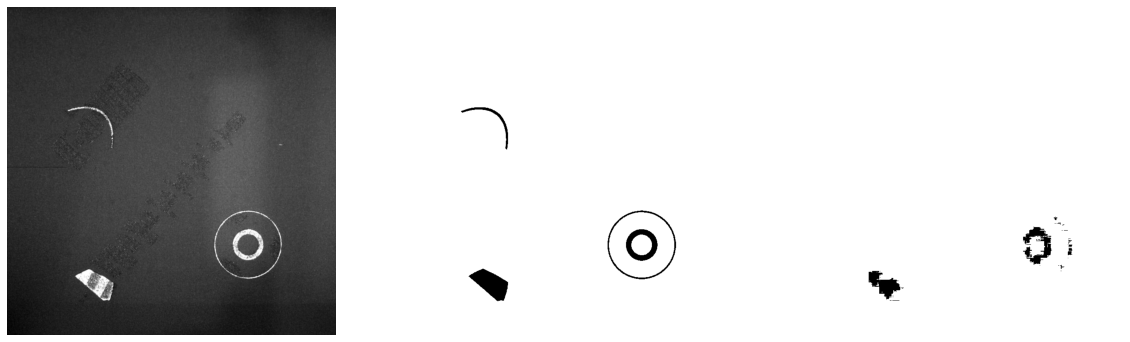

In [15]:
filename="SI377320210706074338_012480.png"
img = load_img("Job_Images/" + filename, color_mode="grayscale")


ref_img=load_img("Reference_Images/" + filename, color_mode="grayscale")
# Colormap Definitions
clist = [(0/255,"white"),(1,"black")]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("name", clist)
clist = [(0/255,"white"),(1,(228/255,108/255,10/255))]
cmap_orange = matplotlib.colors.LinearSegmentedColormap.from_list("name", clist)



import datetime

start = datetime.datetime.now()
mask=predict_model_mask(img, model)
end = datetime.datetime.now()
delta=end-start
print(delta)
print(int(delta.total_seconds() * 1000)) # milliseconds

img_size = (750,750)
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 10))
ax0.imshow(img,cmap='gray');ax0.axis('off')
ax1.imshow(ref_img,cmap=cmap);ax1.axis('off')
ax2.imshow(mask, cmap=cmap);ax2.axis('off')

## Evaluate Images

In [83]:

kernel = np.ones((7,7),np.uint8)
offset_ref=5
img_size = (750,750)
df_final=[]
ref_path="Reference_Images"
input_dir = "Job_Images/"
for filename_job in jobfilenames2:
    data=[]
    all_part_ids=[]
    for filename in filename_job:
      # read reference image
        
          ref_img=load_img("Reference_Images/" + filename, color_mode="grayscale")
          #convert [1,2] to [0,1]
          ref_img=ref_img-np.ones((750,750),np.uint8)
          # read camera image
          
          img = load_img(input_dir+filename, target_size=img_size, color_mode="grayscale")
          
          # predict mask
          mask=predict_model_mask(img, model)
          
          # ref image part ids
          part_ids=np.unique(ref_img)
          
          #calculate height from filename
          height = filename.split("_")[1]
          height = int(height.split(".")[0])

          # iterate over part ids (skip first one, because thats always zero)
          for i in range(1,len(part_ids)):
          # ref_img Bild vorbereiten, bei dem nur Pixel mit bestimmter Partid 1 sind
          # zuerst Zeilennummer (y) dann Spaltennummer (x)
            idx_y, idx_x=np.where(ref_img==1)
            if (idx_y.size!=0) and (idx_x.size!=0):
              # get regions of interests
              roi_ref, coordinates_ref=img_roi(idx_x, idx_y,offset_ref,offset_ref,ref_img)
              roi_mask, coordinates_mask=img_roi(idx_x, idx_y,offset_ref,offset_ref,mask)
              # dilation of ref picture
              dilation = cv.dilate(roi_ref,kernel,iterations = 1)
              # check if pixels of dilated ref are in mask, to eliminate other parts in mask
              mask_part_only=get_right_pixels_of_part(roi_ref, dilation, roi_mask)
              # get centroids and areas
              center_ref, area_ref=img_area_centers(roi_ref)
              #print("klein: ", area_ref, ", groß: ", area_ref2, ", Laser (1. 8 Bits): ", np.sum(np.array(ref[:,:,1])==part_ids[i]))
              center_mask, area_mask=img_area_centers(mask_part_only)
              # calculate vector between the two centers
              center_vector=np.asarray(center_ref)-np.asarray(center_mask)
              length_center_vector=np.sqrt(center_vector.dot(center_vector))
              angle=angle_between(center_ref, center_mask)*180/np.pi
              # calculate area of substracted images
              mask_part_only=mask_part_only.astype('uint8')
              substracted=substract_mask_from_ref(roi_ref,mask_part_only)
              unique_vals,unique_counts=np.unique(substracted,return_counts=True)
              index=np.where(unique_vals==1) # get ones
              subst=unique_counts[index][0]
              # save calculations
              row=[height,area_ref,area_mask,center_ref[0],center_ref[1],center_mask[0],center_mask[1],length_center_vector,angle,part_ids[i],subst]
              data.append(row)


          
    df_final.append(data)
                
            


In [84]:
for data_frame in df_final:
    df=pd.DataFrame(data_frame)
    df.columns = ['height', 'reference_area','predicted_area','reference_x_centroid','reference_y_centroid','predicted_x_centroid','predicted_y_centroid','length_center_vector','angle','part_id','substracted'] 
    display(df)

,height,reference_area,predicted_area,reference_x_centroid,reference_y_centroid,predicted_x_centroid,predicted_y_centroid,length_center_vector,angle,part_id,substracted
0,12000,8162,3930,236.229111,322.195173,252.402799,358.671247,39.901030,1.113686,1,5572
1,12030,8228,4600,236.792781,322.054934,228.486957,359.945435,38.790163,3.918750,1,4996
2,12060,8206,4980,236.669876,322.625762,254.821486,361.571888,42.968380,1.088145,1,5086
3,12090,8224,4751,236.256688,322.476532,240.986108,361.438224,39.247685,2.534643,1,5159
4,12120,8231,4868,236.392783,322.871219,223.019926,368.058751,47.124796,4.996859,1,4759
5,12150,8277,4547,236.735532,322.698200,259.955355,357.345503,41.708462,0.229775,1,5318
6,12180,8263,3758,236.432167,323.012828,243.876530,360.021554,37.750024,2.089114,1,5605
7,12210,8282,4932,236.577035,323.040087,235.675182,363.859084,40.828958,3.285489,1,4870
8,12240,8298,4561,236.608339,324.555435,226.511072,367.998027,44.600601,4.479672,1,4959
9,12270,8345,4901,236.747034,323.755902,226.741277,369.334218,46.663669,4.629647,1,4880


,height,reference_area,predicted_area,reference_x_centroid,reference_y_centroid,predicted_x_centroid,predicted_y_centroid,length_center_vector,angle,part_id,substracted
0,5010,2085,181,235.639329,173.391847,130.104972,165.497238,105.829226,15.480523,1,2002
1,5040,2096,298,235.582061,172.570611,237.312081,167.963087,4.921609,0.934015,1,1924
2,5070,2105,310,235.936817,172.616627,196.629032,190.032258,42.993094,7.832546,1,1945
3,5100,2089,502,234.500718,171.904739,160.334661,179.912351,74.597090,12.049234,1,1843
4,5130,2089,500,234.588320,171.665869,201.104000,148.796000,40.549113,0.301849,1,1807
5,5160,2092,524,234.717495,171.733748,179.515267,156.820611,57.181183,4.948255,1,1822
6,5190,2088,521,235.615421,171.450192,160.117083,157.842610,76.714832,8.547906,1,1823
7,5220,2090,535,235.386603,171.801914,186.882243,144.820561,55.503751,1.648529,1,1819
8,5250,2112,504,236.276515,173.420928,177.039683,149.750000,63.791184,3.948679,1,1842
9,5280,2118,531,235.605288,173.777620,172.082863,181.638418,64.006958,10.135710,1,1869


,height,reference_area,predicted_area,reference_x_centroid,reference_y_centroid,predicted_x_centroid,predicted_y_centroid,length_center_vector,angle,part_id,substracted
0,55020,14564,2855,254.114872,231.289275,315.810158,379.398949,160.445579,7.918427,1,13491
1,55050,14492,4301,253.318521,231.494480,313.188096,292.532202,85.498360,0.624343,1,12607
2,55080,14495,3060,253.174750,231.498310,257.869935,372.526144,141.105970,12.869036,1,13331
3,55110,14567,3313,253.291755,231.753553,306.907335,312.712043,97.102562,3.079263,1,12932
4,55140,14463,3925,253.567241,231.345710,311.613758,309.042548,96.985550,2.386431,1,12582
5,55170,14495,2788,253.616212,231.595654,299.032281,383.661047,158.702562,9.665005,1,13427
6,55200,14506,3218,253.757755,231.277265,314.295525,285.949969,81.571601,0.050030,1,13038
7,55230,14476,3507,253.105347,231.561896,295.251782,344.453379,120.502320,6.943248,1,12953
8,55260,14444,3191,253.389574,231.511077,297.207772,366.848637,142.254313,8.570241,1,13221
9,55290,14443,3021,253.331787,231.375407,330.599801,280.333664,91.472712,2.109940,1,12986


,height,reference_area,predicted_area,reference_x_centroid,reference_y_centroid,predicted_x_centroid,predicted_y_centroid,length_center_vector,angle,part_id,substracted
0,118020,11064,7914,109.493492,227.498102,110.111195,289.569497,62.074469,4.881517,1,6718
1,118050,11067,10324,109.521731,227.491371,106.357904,247.026153,19.789328,2.413224,1,5655
2,118080,11059,11152,109.502306,227.567682,105.712877,234.757353,8.127185,1.453822,1,5611
3,118110,11045,6477,109.500951,226.729470,110.300757,337.734908,111.008319,7.692113,1,7936
4,118140,11062,10843,109.566534,226.670222,107.347598,236.867564,10.435970,1.418047,1,5695
5,118170,11054,10237,109.522978,226.703003,107.562274,245.241575,18.641968,2.103630,1,5709
6,118200,11045,6680,109.586238,226.751833,110.243713,340.497006,113.747073,7.853330,1,7749
7,118230,11033,10542,109.510559,226.687030,109.353633,237.292734,10.606865,1.042719,1,5903
8,118260,11043,9430,109.540614,226.570044,107.838706,266.184836,39.651333,3.748330,1,6289
9,118290,11033,9949,109.547086,226.713677,106.165042,250.307669,23.835156,2.805981,1,5816


In [ ]:
for data_frame in df_final:
    dataframe=pd.DataFrame(data_frame)
    unique=np.unique(dataframe[9])
    # check if there is data in data
    if dataframe.size!=0:
        matplotlib.rc('font', size=12)
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(1, 1, 1)
        fig2 = plt.figure(figsize=(20,8))
        ax2 = fig2.add_subplot(1, 1, 1)
        fig3 = plt.figure(figsize=(20,8))
        ax3 = fig3.add_subplot(1, 1, 1)
    
        legend=[]
        legend2=[]
        for un in unique:
            data_part=dataframe.loc[dataframe[9]==un]
            data=np.asarray(data_part)
            normed=1
            #normed=norm_results(-10,data[:,1],data[:,2]) # only if normalized results are wanted
            normed_data=normed*data[:,2]
            ax.plot((data[:,0])/1e3,data[:,1]/9,data[:,0]/1e3,normed_data/9)

            ax2.plot((data[:,0])/1e3,data[:,7]/3)
            
            ax3.plot((data[:,0])/1e3, (data[:,1]-data[:,10])/data[:,1]*100)
            
            
            legend.append("part " +str(un)+" target")
            legend.append("part " +str(un)+" actual")
            legend2.append("part "+str(un))

        ax.set_xlabel('height [mm]')
        ax.set_ylabel('Area [mm$^2$]')
        ax.grid(which='both')
        ax.legend(legend)
   
        fig.show()

        ax2.set_xlabel('height [mm]')
        ax2.set_ylabel('Distance between centroids [mm]')
        ax2.grid(which='both')
        ax2.legend(legend2)
        
        fig2.show()
        
        ax3.set_xlabel('height [mm]')
        ax3.set_ylabel('Bitwise XOR')
        ax3.grid(which='both')
        ax3.legend(legend2)
        
        fig3.show()        
         